In [1]:
!pip install deeplake
!pip install llama-index
!pip install llama-index-llms-openai
!pip install llama-index-vector-stores-deeplake
!pip install sentence-transformers
!pip install langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.7/618.7 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 12.5 MB/s eta 0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.5 MB/s eta 0:00:00


In [1]:

import os
import requests
import re
import openai

from google.colab import userdata
from bs4 import BeautifulSoup

In [2]:
LLM_PATH = './contents/'

## 1.Source Retrieval

In [3]:
class SourceRetrieval:
  def __init__(self):
    openai.api_key = userdata.get('OPENAI_API_KEY')
    os.environ['USER_AGENT'] = 'RAGUserAgent'
    os.environ['ACTIVELOOP_TOKEN']= userdata.get('ACTIVELOOP_TOKEN')


    self.urls = [
        "https://github.com/VisDrone/VisDrone-Dataset",
        "https://paperswithcode.com/dataset/visdrone",
        "https://openaccess.thecvf.com/content_ECCVW_2018/papers/11133/Zhu_VisDrone-DET2018_The_Vision_Meets_Drone_Object_Detection_in_Image_Challenge_ECCVW_2018_paper.pdf",
        "https://github.com/VisDrone/VisDrone2018-MOT-toolkit",
        "https://en.wikipedia.org/wiki/Object_detection",
        "https://en.wikipedia.org/wiki/Computer_vision",
        "https://en.wikipedia.org/wiki/Convolutional_neural_network",
        "https://en.wikipedia.org/wiki/Unmanned_aerial_vehicle",
        "https://www.faa.gov/uas/",
        "https://www.tensorflow.org/",
        "https://pytorch.org/",
        "https://keras.io/",
        "https://arxiv.org/abs/1804.06985",
        "https://arxiv.org/abs/2202.11983",
        "https://motchallenge.net/",
        "http://www.cvlibs.net/datasets/kitti/",
        "https://www.dronedeploy.com/",
        "https://www.dji.com/",
        "https://arxiv.org/",
        "https://openaccess.thecvf.com/",
        "https://roboflow.com/",
        "https://www.kaggle.com/",
        "https://paperswithcode.com/",
        "https://github.com/"
    ]

  def get_contents(self):
    def clean_text(content):
      content = re.sub(r'\[\s*(\d+|edit)\s*\]','',content)
      content = re.sub(r'[^\w\s\.]','',content)
      return content

    def fetch(url):
      try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        content = soup.find('div',{'class': 'mw-parser-output'}) or soup.find('div', {'id': 'content'})
        if content is None:
            return None

        for section_title in ['References', 'Bibliography', 'External links', 'See also', 'Notes']:
            section = content.find('span',id=section_title)
            while section:
                for sib in section.parent.find_next_siblings():
                    sib.decompose()
                section.parent.decompose()
                section = content.find('span',id=section_title)

        text = content.get_text(separator=' ', strip=True)
        text = clean_text(text)
        return text
      except requests.exceptions.RequestException as e:
        print(f'error from {url}: {e}')
        return None

    for url in self.urls:
      article = url.split('/')[-1].replace('.html','')

      filename = os.path.join(LLM_PATH, f'{article}.txt')
      clean_article = fetch(url)
      if clean_article:
          with open(filename,'w',encoding='utf-8') as file:
              file.write(clean_article)
              print(f'\tContent was written to {filename}')

    print('Content writing done...')



In [4]:
sr = SourceRetrieval()
sr.get_contents()

	Content was written to ./contents/Object_detection.txt
	Content was written to ./contents/Computer_vision.txt
	Content was written to ./contents/Convolutional_neural_network.txt
	Content was written to ./contents/Unmanned_aerial_vehicle.txt
	Content was written to ./contents/1804.06985.txt
	Content was written to ./contents/2202.11983.txt
	Content was written to ./contents/.txt
	Content was written to ./contents/.txt
	Content was written to ./contents/.txt
Content writing done...


## 2. Vectorizing

In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from llama_index.core import StorageContext,\
                             VectorStoreIndex,\
                             SimpleDirectoryReader,\
                             Document

from llama_index.vector_stores.deeplake import DeepLakeVectorStore

#from pydantic.v1 import BaseModel,Field
#from typing import ClassVar
import deeplake


/usr/local/lib/python3.10/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.2) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [6]:
class VectorStore:
  def __init__(self):
    self.documents = SimpleDirectoryReader(LLM_PATH).load_data()
    self.vector_path = 'hub://pythoninaction/drone_1000'
    self.dataset_path = 'hub://pythoninaction/drone_1000'
    self.gemini_embedding  = GoogleGenerativeAIEmbeddings(model='models/embedding-001')

  def vectorize(self):
    vector_store = DeepLakeVectorStore(dataset_path=self.dataset_path, overwrite=True)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(self.documents, storage_context=storage_context)
    ds = deeplake.load(self.dataset_path)
    return ds,index

In [7]:
vs = VectorStore()
ds,index = vs.vectorize()

Your Deep Lake dataset has been successfully created!


Uploading data to deeplake dataset.


100%|██████████| 83/83 [00:01<00:00, 75.26it/s]


Dataset(path='hub://pythoninaction/drone_1000', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype      shape      dtype  compression
  -------    -------    -------    -------  ------- 
   text       text      (83, 1)      str     None   
 metadata     json      (83, 1)      str     None   
 embedding  embedding  (83, 1536)  float32   None   
    id        text      (83, 1)      str     None   


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/pythoninaction/drone_1000



\

hub://pythoninaction/drone_1000 loaded successfully.



In [8]:
import json
import numpy as np
import pandas as pd

In [9]:
print(type(ds))

<class 'deeplake.core.dataset.deeplake_cloud_dataset.DeepLakeCloudDataset'>


In [10]:
data_llm = {}
for tensor_name in ds.tensors:
  tensor_data = ds[tensor_name].numpy()

  if tensor_data.ndim > 1:
    data_llm[tensor_name] = [np.array(e).flatten().tolist() for e in tensor_data]
  else:
    if tensor_name == 'text':
      data_llm[tensor_name] = [t.tobytes().decode('utf-8') if t else "" for t in tensor_data]
    else:
      data_llm[tensor_name] = tensor_data.tolist()

df_llm = pd.DataFrame(data_llm)
df_llm

embedding  \
0   [-0.00045715272426605225, 0.009917649440467358...   
1   [-0.014190182089805603, 0.01753275841474533, 0...   
2   [-0.017965424805879593, -0.0010230127954855561...   
3   [-0.014219841919839382, -0.003627510741353035,...   
4   [-0.01666109450161457, 0.002121962606906891, 0...   
..                                                ...   
78  [-0.003545360639691353, 4.073099626111798e-05,...   
79  [-0.018628675490617752, -0.010554015636444092,...   
80  [-0.016959553584456444, -0.010973043739795685,...   
81  [-0.015471203252673149, -0.005759623367339373,...   
82  [-0.020012931898236275, 0.002491474850103259, ...   

                                        id  \
0   [f03d281b-443d-4ea0-91e2-1b4846dd8148]   
1   [2f7201ce-3f71-4cdc-be17-2f51c446c614]   
2   [71c6585f-841a-42bd-9b0c-62d2e6763e1a]   
3   [d96f146c-3960-4111-b5d1-4efc9aa5ac36]   
4   [99a793ff-5d2c-4f48-a2df-7d5055d1cf1c]   
..                                     ...   
78  [8e782556-4761-438d-9003-897f37948c70]   
79  [ad9b5cc5-8f17-4ef3-a7ec-facb2314ad93]   
80  [9aed7fde-0657-4269-bf45-f8de3ce2445c]   
81  [d3fdd6d1-bfea-4fc4-a79c-be6262521621]   
82  [b21f42e0-d006-4a2b-9b1c-92c6f1957ac4]   

                                             metadata  \
0   [{'file_path': '/content/contents/1804.06985.t...   
1   [{'file_path': '/content/contents/2202.11983.t...   
2   [{'file_path': '/content/contents/Computer_vis...   
3   [{'file_path': '/content/contents/Computer_vis...   
4   [{'file_path': '/content/contents/Computer_vis...   
..                                                ...   
78  [{'file_path': '/content/contents/Unmanned_aer...   
79  [{'file_path': '/content/contents/Unmanned_aer...   
80  [{'file_path': '/content/contents/Unmanned_aer...   
81  [{'file_path': '/content/contents/Unmanned_aer...   
82  [{'file_path': '/content/contents/Unmanned_aer...   

                                                 text  
0   [High Energy Physics  Theory arXiv1804.06985 h...  
1   [Computer Science  Computer Vision and Pattern...  
2   [Computerized information extraction from imag...  
3   [By the 1990s some of the previous research to...  
4   [Some strands of computer vision research are ...  
..                                                ...  
78  [Biological Invasions . 26 2 357363. doi  10.1...  
79  [Journal of Rock Mechanics and Geotechnical En...  
80  [CNN . Archived from the original on 8 Novembe...  
81  [Formation Control for UAVs Using a Flux Guide...  
82  [Lightning Bugs  Buffalo Hunters The Ryan Mode...  

[83 rows x 4 columns]

In [11]:
df_llm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   embedding  83 non-null     object
 1   id         83 non-null     object
 2   metadata   83 non-null     object
 3   text       83 non-null     object
dtypes: object(4)
memory usage: 2.7+ KB


In [12]:
df_llm['text'] = df_llm['text'].astype(str)
df_llm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   embedding  83 non-null     object
 1   id         83 non-null     object
 2   metadata   83 non-null     object
 3   text       83 non-null     object
dtypes: object(4)
memory usage: 2.7+ KB


In [13]:
document_llms = [Document(text=row['text'], doc_id=str(row['id'])) for _, row in df_llm.iterrows()]
document_llms[0]

Document(id_="['f03d281b-443d-4ea0-91e2-1b4846dd8148']", embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text="['High Energy Physics  Theory arXiv1804.06985 hepth Submitted on 19 Apr 2018 Title A Near Horizon Extreme Binary Black Hole Geometry Authors Jacob Ciafre  Maria J. Rodriguez View a PDF of the paper titled A Near Horizon Extreme Binary Black Hole Geometry by Jacob Ciafre and Maria J. Rodriguez View PDF Abstract A new solution of fourdimensional vacuum General Relativity is presented. It describes the near horizon region of the extreme maximally spinning binary black hole system with two identical extreme Kerr black holes held in equilibrium by a massless strut. This is the first example of a nonsupersymmetric asymptotically flat near horizon extreme binary black hole geometry of two uncharged black holes. The black holes are corotating and the solution is uniquely specified by the mass. The binary extreme system has

## 3.Query Engine

In [14]:
from llama_index.core import VectorStoreIndex

In [15]:
vector_store_engine_llm = VectorStoreIndex.from_documents(document_llms)
vector_query_engine_llm = vector_store_engine_llm.as_query_engine(similarity_top_k=10, temperatur=0.1, num_output=1024)

In [16]:

user_input="How do drones recognize car?"
import time
import textwrap
#start the timer
start_time = time.time()
llm_response = vector_query_engine_llm.query(user_input)
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(textwrap.fill(str(llm_response), 100))

Query execution time: 1.8929 seconds
Drones can recognize cars through various methods such as computer vision technology, sensors like
cameras and LiDAR, and machine learning algorithms. These technologies allow drones to capture
images or data of cars, analyze them, and identify specific features or patterns that help in
recognizing and tracking cars during surveillance or monitoring operations.


## 4. Visualize

In [17]:
import deeplake

In [18]:
class VisualizeVector:
  def __init__(self):
    self.dataset_path = 'hub://activeloop/visdrone-det-train'
    self.ds = deeplake.load(self.dataset_path)

  def createStructure(self):
    df = pd.DataFrame(columns=['image','boxes','labels'])

    for i, sample in enumerate(self.ds):
       df.loc[i, 'image'] = sample.images.tobytes()
       boxes_list = sample.boxes.numpy(aslist=True)
       df.loc[i, 'boxes'] = [box.tolist() for box in boxes_list]

       label_data = sample.labels.data()
       df.loc[i, 'labels'] = label_data['text']

    return df,self.ds



In [19]:
vv = VisualizeVector()
df,ds = vv.createStructure()

/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/visdrone-det-train



\

hub://activeloop/visdrone-det-train loaded successfully.



In [ ]:
df

image  \
0     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4     b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
...                                                 ...   
6466  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6467  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6468  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6469  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
6470  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

                                                  boxes  \
0     [[1221.0, 84.0, 16.0, 33.0], [1235.0, 71.0, 18...   
1     [[351.0, 936.0, 305.0, 114.0], [0.0, 818.0, 22...   
2     [[699.0, 716.0, 26.0, 54.0], [600.0, 604.0, 22...   
3     [[417.0, 77.0, 57.0, 54.0], [387.0, 109.0, 31....   
4     [[794.0, 617.0, 97.0, 115.0], [803.0, 539.0, 7...   
...                                                 ...   
6466  [[683.0, 710.0, 7.0, 6.0], [681.0, 717.0, 5.0,...   
6467  [[1761.0, 676.0, 207.0, 155.0], [1539.0, 648.0...   
6468  [[0.0, 501.0, 105.0, 93.0], [412.0, 594.0, 172...   
6469  [[200.0, 604.0, 112.0, 64.0], [311.0, 560.0, 1...   
6470  [[60.0, 144.0, 16.0, 21.0], [51.0, 120.0, 15.0...   

                                                 labels  
0     [pedestrian, pedestrian, tricycle, pedestrian,...  
1     [car, car, car, car, car, car, car, car, car, ...  
2     [truck, car, van, car, car, car, car, car, car...  
3     [ignored regions, ignored regions, car, car, c...  
4     [car, car, car, car, car, car, car, car, car, ...  
...                                                 ...  
6466  [car, car, car, car, awning-tricycle, car, car...  
6467  [car, car, car, car, car, van, car, car, car, ...  
6468  [car, van, pedestrian, pedestrian, pedestrian,...  
6469  [van, truck, van, car, car, van, others, car, ...  
6470  [people, pedestrian, others, people, people, m...  

[6471 rows x 3 columns]

In [20]:
labels_list = ds.labels.info['class_names']
labels_list

['ignored regions',
 'pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor',
 'others']

## Multi-model structure

#### Getting image

In [22]:
import deeplake
from IPython.display import Image, display
from PIL import Image
import cv2

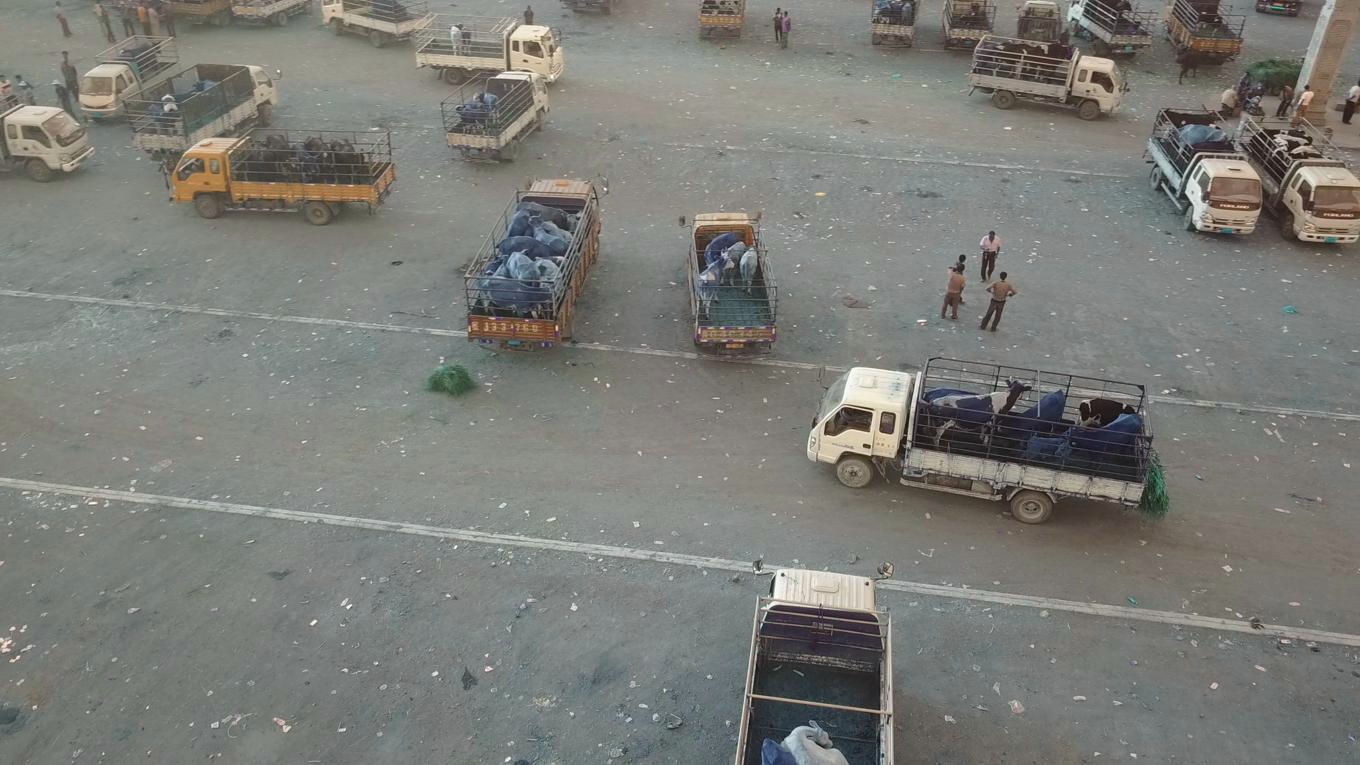

In [25]:
ind = 0
image = ds.images[ind].numpy()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = Image.fromarray(image_rgb)
display(img)

#### Adding bounding boxes and saving

In [28]:
labels = ds.labels[ind].data()
labels

{'value': array([1, 1, 7, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6,
        1, 1, 1, 1, 1, 1, 6, 6, 3, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 6, 6, 6], dtype=uint32),
 'text': ['pedestrian',
  'pedestrian',
  'tricycle',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'truck',
  'truck',
  'truck',
  'truck',
  'truck',
  'truck',
  'truck',
  'truck',
  'truck',
  'truck',
  'pedestrian',
  'truck',
  'truck',
  'truck',
  'truck',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'truck',
  'truck',
  'bicycle',
  'truck',
  'truck',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'pedestrian',
  'truck',
  'truck',
  'truck']}

In [31]:
values = labels['value']
text_labels = labels['text']
max_text_length = max(len(label) for label in text_labels)

In [32]:
# Print the header
print(f"{'Index':<10}{'Label':<{max_text_length + 2}}")
print("-" * (10 + max_text_length + 2))  # Add a separator line

# Print the indices and labels in two columns
for index, label in zip(values, text_labels):
    print(f"{index:<10}{label:<{max_text_length + 2}}")

Index     Label       
----------------------
1         pedestrian  
1         pedestrian  
7         tricycle    
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
6         truck       
1         pedestrian  
6         truck       
6         truck       
6         truck       
6         truck       
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
6         truck       
6         truck       
3         bicycle     
6         truck       
6         truck       
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         pedestrian  
1         p

In [33]:
ds.labels[ind].info['class_names']

['ignored regions',
 'pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor',
 'others']

In [34]:
def display_image_with_bboxes(image_data, bboxes, labels, label_name, ind=0):
    #Displays an image with bounding boxes for a specific label.

    image_bytes = io.BytesIO(image_data)
    img = Image.open(image_bytes)

    # Extract class names specifically for the selected image
    class_names = ds.labels[ind].info['class_names']

    # Filter for the specific label (or display all if class names are missing)
    if class_names is not None:
        try:
            label_index = class_names.index(label_name)
            relevant_indices = np.where(labels == label_index)[0]
        except ValueError:
            print(f"Warning: Label '{label_name}' not found. Displaying all boxes.")
            relevant_indices = range(len(labels))
    else:
        relevant_indices = []  # No labels found, so display no boxes

    # Draw bounding boxes
    draw = ImageDraw.Draw(img)
    for idx, box in enumerate(bboxes):  # Enumerate over bboxes
        if idx in relevant_indices:   # Check if this box is relevant
            x1, y1, w, h = box
            x2, y2 = x1 + w, y1 + h
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1), label_name, fill="red")
    # Save the image
    save_path="boxed_image.jpg"
    img.save(save_path)
    display(img)

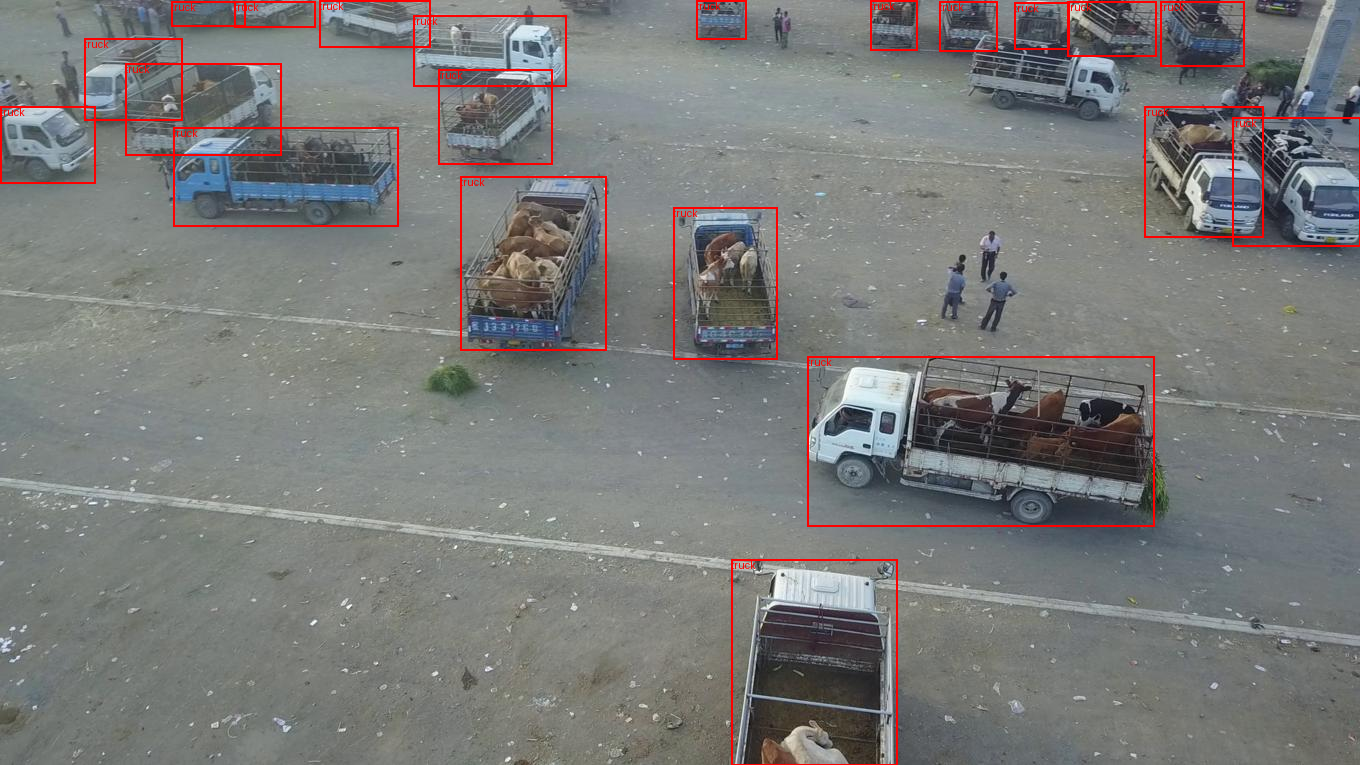

In [35]:

import io
from PIL import ImageDraw
# Fetch labels and image data for the selected image
labels = ds.labels[ind].data()['value']
image_data = ds.images[ind].tobytes()
bboxes = ds.boxes[ind].numpy()
ibox="truck" # class in image

# Display the image with bounding boxes for the label chosen
display_image_with_bboxes(image_data, bboxes, labels, label_name=ibox)